<a href="https://colab.research.google.com/github/shekharkhandelwal1983/DLforDataArchitects/blob/main/notebooks/chapter7/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


In [2]:
import tensorflow_datasets as tfds

# Download the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCYA7MO/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteCYA7MO/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)


In [5]:
def build_unet(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    up1 = layers.concatenate([layers.UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.concatenate([layers.UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output Layer
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(conv5)

    return keras.Model(inputs=inputs, outputs=outputs)

# Build U-Net model
model = build_unet((128, 128, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [6]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)


Epoch 1/10
57/57 [==============================] - 65s 600ms/step - loss: 0.8726 - accuracy: 0.5978 - val_loss: 0.7856 - val_accuracy: 0.6396
Epoch 2/10
57/57 [==============================] - 44s 614ms/step - loss: 0.7342 - accuracy: 0.6643 - val_loss: 0.7005 - val_accuracy: 0.6931
Epoch 3/10
57/57 [==============================] - 34s 594ms/step - loss: 0.6680 - accuracy: 0.7016 - val_loss: 0.6171 - val_accuracy: 0.7386
Epoch 4/10
57/57 [==============================] - 32s 556ms/step - loss: 0.6264 - accuracy: 0.7279 - val_loss: 0.5958 - val_accuracy: 0.7448
Epoch 5/10
57/57 [==============================] - 32s 559ms/step - loss: 0.5588 - accuracy: 0.7634 - val_loss: 0.5293 - val_accuracy: 0.7800
Epoch 6/10
57/57 [==============================] - 31s 553ms/step - loss: 0.5353 - accuracy: 0.7746 - val_loss: 0.5587 - val_accuracy: 0.7619
Epoch 7/10
57/57 [==============================] - 32s 559ms/step - loss: 0.5114 - accuracy: 0.7855 - val_loss: 0.4944 - val_accuracy: 0.7976

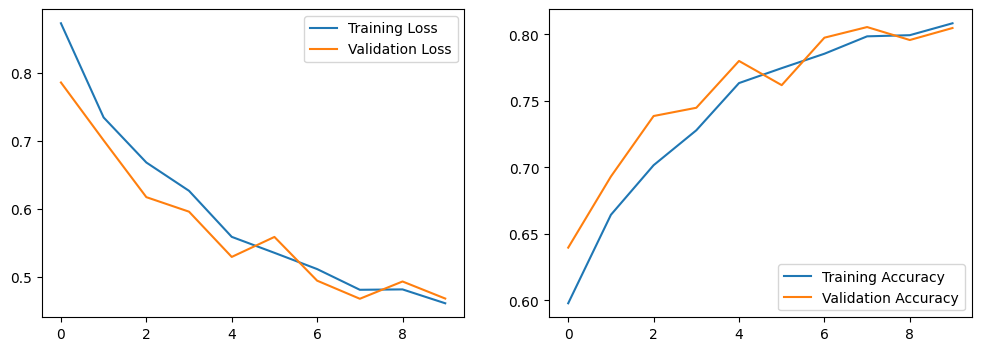

2/2 [==============================] - 0s 108ms/step


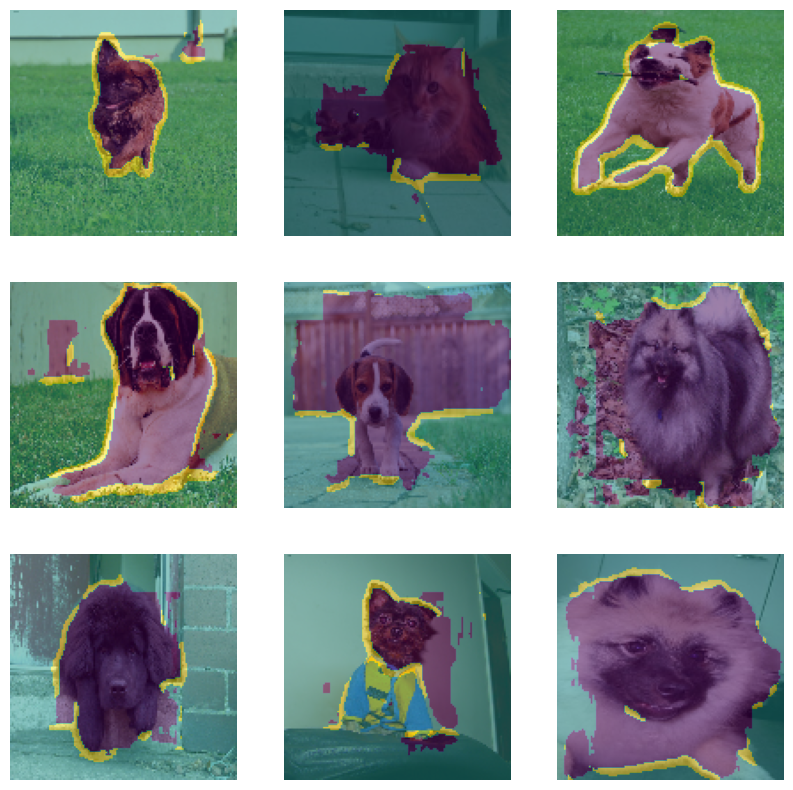

In [7]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history["loss"], label="Training Loss")
plt.plot(model_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(model_history.history["accuracy"], label="Training Accuracy")
plt.plot(model_history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

# Visualize predictions
for image, mask in test_dataset.take(1):
    pred_mask = model.predict(image)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.imshow(np.argmax(pred_mask[i], axis=-1), alpha=0.5)
        plt.axis("off")
    plt.show()
